# Dependies

In [1]:

import tensorflow
print(tensorflow.__version__)


2.12.0


# importing the dataset

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="VFQrSXI3PXI5ppUKRxg3")
project = rf.workspace("hari-narayanan").project("eye-disease-classification-4hotj")
dataset = project.version(1).download("folder")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.6 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=b571833d901314f5a72c8f2150bd5353abe0dd5d3bd417ae08d80a1693532869
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall: idna
    Found e

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to eye-disease-classification-1 in folder:: 100%|██████████| 1627/1627 [00:00<00:00, 3200.74it/s]


# Data Preprocessing

In [3]:
import cv2,os
data_path='/content/eye-disease-classification-1/train'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary
print(label_dict)
print(categories)
print(labels)

{'Diabetic': 0, 'Hypertensive': 1, 'Others': 2, 'Normal': 3, 'Myopia': 4, 'Glaucoma': 5, 'Cataract': 6}
['Diabetic', 'Hypertensive', 'Others', 'Normal', 'Myopia', 'Glaucoma', 'Cataract']
[0, 1, 2, 3, 4, 5, 6]


In [4]:
img_size=100
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)

    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            resized=cv2.resize(img,(img_size,img_size))
            #resizing the image  into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

# Recale and assign catagorical

In [5]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,3))
target=np.array(target)
from keras.utils import np_utils
new_target=np_utils.to_categorical(target)

In [6]:

new_target.shape

(1118, 7)

In [7]:

data.shape

(1118, 100, 100, 3)

In [8]:

data.shape[1:]

(100, 100, 3)

# CNN Model

In [23]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(7,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 200)       5600      
                                                                 
 activation_2 (Activation)   (None, 98, 98, 200)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 200)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 100)       180100    
                                                                 
 activation_3 (Activation)   (None, 47, 47, 100)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 100)      0         
 2D)                                                  

# Splitting data into training and testing

In [25]:

from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,new_target,test_size=0.1)

In [26]:
train_data.shape

(1006, 100, 100, 3)

In [27]:

train_target.shape

(1006, 7)

In [28]:
#checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=100,validation_split=0.2)

Epoch 1/100
26/26 [==============================] - 14s 64ms/step - loss: 1.9574 - accuracy: 0.1580 - val_loss: 1.9103 - val_accuracy: 0.1337
Epoch 2/100
26/26 [==============================] - 1s 40ms/step - loss: 1.8885 - accuracy: 0.2077 - val_loss: 1.8871 - val_accuracy: 0.1733
Epoch 3/100
26/26 [==============================] - 1s 42ms/step - loss: 1.8308 - accuracy: 0.2450 - val_loss: 1.8780 - val_accuracy: 0.2624
Epoch 4/100
26/26 [==============================] - 1s 40ms/step - loss: 1.7872 - accuracy: 0.2935 - val_loss: 1.7876 - val_accuracy: 0.3267
Epoch 5/100
26/26 [==============================] - 1s 37ms/step - loss: 1.7438 - accuracy: 0.3159 - val_loss: 1.7304 - val_accuracy: 0.2871
Epoch 6/100
26/26 [==============================] - 1s 36ms/step - loss: 1.6946 - accuracy: 0.3209 - val_loss: 1.7127 - val_accuracy: 0.3020
Epoch 7/100
26/26 [==============================] - 1s 39ms/step - loss: 1.6676 - accuracy: 0.3520 - val_loss: 1.7668 - val_accuracy: 0.3119
Epoch

In [29]:
model.save('model.h5')

In [30]:
from matplotlib import pyplot as plt

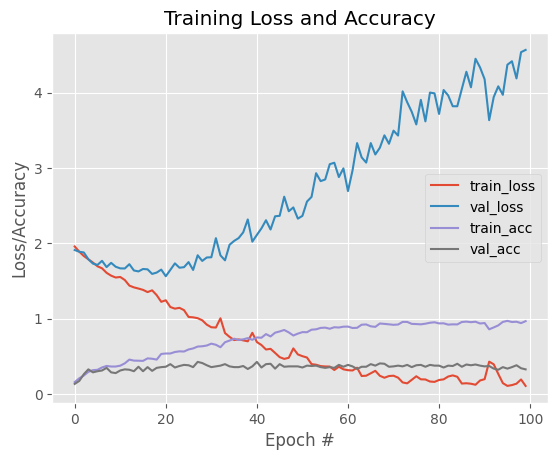

In [32]:
# plot the training loss and accuracy
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")